# Votes vs. Vaccinations

Recently, I spotted a curious swarm chart in NPR's coverage of the Covid-19 vaccine rollout <a href="https://www.npr.org/sections/health-shots/2021/01/28/960901166/how-is-the-covid-19-vaccination-campaign-going-in-your-state">here</a> under the section, "Which States Are Leading In The Race To Get Their Populations Vaccinated?" 

When states are sorted by percent of the population who is fully vaccinated, there are a few states out ahead, a few behind, and a bunch in the middle. Interestingly, when states are sorted by percent of the population who has received at least one dose, a different pattern emerges: two distinct clumps. Why?

It occurred to me that the fully vaccinated data reflect the supply and demand of vaccine at least 3-4 weeks ago, in order for those people to have received both doses. On the other hand, the at least one dose data reflects the situation right now. One explanation would be that a month ago, vaccine uptake was limited by the supply of vaccine and now, vaccine uptake is limited by the supply of willing arms. A cursory glance at the two clumps leads to an obvious hypothsis on what makes arms willing: political alignment. Does percentage of a state populations who voted for Trump in 2020 correlate with the percentage with at least one dose of Covid-19 vaccine as of May 20th, 2021?

## Data Sources

Data on percent vaccination by state is from the CDC:

https://covid.cdc.gov/covid-data-tracker/#vaccinations

Data on percent Trump votes by state is from the Cook Political Report:

https://cookpolitical.com/2020-national-popular-vote-tracker

Neither dataset had each state's population directly, so I calculated this from the number of total vaccines delivered to each state and the vaccines per 100K delivered to each state, which were included in the CDC data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
# Read in election data

votes = pd.read_csv("./data/Popular vote backend - Sheet1.csv")[["state", "rep_percent"]].dropna()

# Percent who voted Republican is a string ending in a percent sign. Strip the % and convert to float.

votes["rep_percent"] = votes["rep_percent"].str.replace("%", "")
votes["rep_percent"] = pd.to_numeric(votes["rep_percent"])
votes.head()

,state,rep_percent
0,U.S. Total,46.9
1,15 Key Battlegrounds,50.1
2,Non-Battlegrounds,44.5
4,Arizona,49.1
5,Florida,51.2


In [3]:
# Read in vaccination data

cols_to_keep = ["State/Territory/Federal Entity", "Total Doses Delivered", "Doses Delivered per 100K",
               "Percent of 18+ Pop with at least One Dose by State of Residence"]
vaccines = pd.read_csv("./data/covid19_vaccinations_in_the_united_states.csv", skiprows=2)[cols_to_keep]
vaccines.head()

,State/Territory/Federal Entity,Total Doses Delivered,Doses Delivered per 100K,Percent of 18+ Pop with at least One Dose by State of Residence
0,Alaska,799005,109222.0,56.8
1,Alabama,4415280,90049.0,44.8
2,Arkansas,2729400,90443.0,48.6
3,American Samoa,54030,97021.0,50.9
4,Arizona,7577625,104107.0,55.8


In [4]:
# The CDC codes New York as "New York State". Change that to "New York" so the merge with the election data works.

vaccines["State/Territory/Federal Entity"].replace({"New York State":"New York"}, inplace=True)

In [5]:
# Calculate each state's population based on data available in the vaccination dataset. Round down to nearest integer.
# Then drop the columns used to do the calculations.

vaccines["Population"] = 100000 * vaccines["Total Doses Delivered"] // vaccines["Doses Delivered per 100K"]
vaccines.drop(columns=["Total Doses Delivered", "Doses Delivered per 100K"], inplace=True)
vaccines.head()

,State/Territory/Federal Entity,Percent of 18+ Pop with at least One Dose by State of Residence,Population
0,Alaska,56.8,731542.0
1,Alabama,44.8,4903197.0
2,Arkansas,48.6,3017812.0
3,American Samoa,50.9,55688.0
4,Arizona,55.8,7278689.0


In [6]:
# Merge the two datasets on state. The vaccination data includes U.S. territories not inlcuded in the election data. 
# The election data includes individual congressional districts for the two states which allot Electoral College votes 
# by district, Maine and Nebraska. An inner join is appropriate here and results in a dataframe with the fifty states 
# and the District of Columbia.

votevax = pd.merge(votes, vaccines, how="inner", left_on="state", right_on="State/Territory/Federal Entity")
votevax.drop(columns=["State/Territory/Federal Entity"], inplace=True)

# Give the remaining columns more user-friendly names, sort by state, and we have a tidy table.
votevax.rename(columns={"state":"State", "rep_percent":"Percent Republican Vote",
                       "Percent of 18+ Pop with at least One Dose by State of Residence":
                        "Percent of 18+ with at least One Dose"}, inplace=True)
votevax.sort_values("State", inplace=True)
votevax.reset_index(inplace=True, drop=True)
votevax.head(52)

,State,Percent Republican Vote,Percent of 18+ with at least One Dose,Population
0,Alabama,62.0,44.8,4903197.0
1,Alaska,52.8,56.8,731542.0
2,Arizona,49.1,55.8,7278689.0
3,Arkansas,62.4,48.6,3017812.0
4,California,34.3,67.5,39512110.0
5,Colorado,41.9,63.6,5758748.0
6,Connecticut,39.2,72.9,3565280.0
7,Delaware,39.8,63.4,973764.0
8,District of Columbia,5.4,66.0,705749.0
9,Florida,51.2,57.1,21477732.0


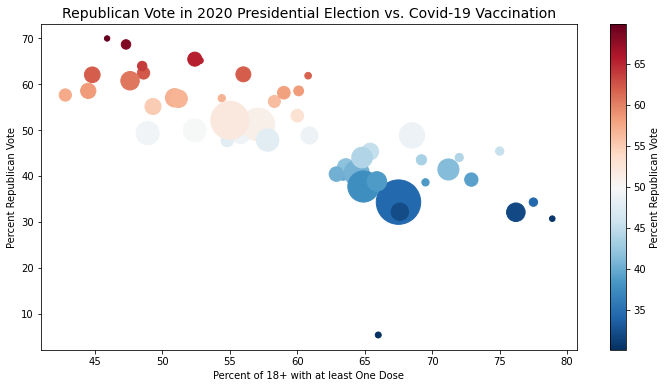

In [7]:
# Plot the data

# Setting color min. Otherwise the District of Columbia, at a mere 5.4% for Trump, 
# pulls the minimum of the color bar so low that most "blue" states are too pale to see.
# Set min as far below 50 as the max is above 50
color_min = 50 - (votevax["Percent Republican Vote"].max() - 50) 

fig, ax = plt.subplots(figsize=(12,6))
votevax.plot.scatter(x="Percent of 18+ with at least One Dose", y="Percent Republican Vote",
                    c="Percent Republican Vote", cmap="RdBu_r", vmin=color_min,
                    s=votevax["Population"]/20000, ax=ax)
ax.set_title("Republican Vote in 2020 Presidential Election vs. Covid-19 Vaccination", fontsize=14)
plt.show()

The percent of a state's population who voted for Trump in 2020 appears to be correlated with the percent who have received at least one dose of Covid-19 vaccine. That can be readily quantified by finding the Pearson correlation coefficient:

In [8]:
R, p = pearsonr(votevax["Percent Republican Vote"], votevax["Percent of 18+ with at least One Dose"])
print(f"Pearson's R is {R:0.2f} with a p-value of {p}.")

Pearson's R is -0.75 with a p-value of 1.8306451879635464e-10.


Correlation is not causation, of course, but the percentage of a state's population who voted for Trump in 2020 is negatively correlated with the percentage of that state's population who has received at least one dose of Covid-19 vaccine with a Pearson's R of -0.75.

## A Little Regression, just for fun

I have put the percent vaccinated on the x axis above to mimic the orientation of NPR's original swarm. However, if the percent who voted Republican in the 2020 Presidential Election is considered a *predictor* of percent vaccinated, then it should righty be on the x axis. In that case, the regression line will predict the percent vaccinated based on previous voting patterns. Let's do a bit of regression and re-graph.

In [9]:
model = LinearRegression()
X = votevax[["Percent Republican Vote"]]
y = votevax["Percent of 18+ with at least One Dose"]
model.fit(X, y)
print(f"Percent Vaxed = {model.coef_[0]:0.2f} * Percent Trump votes + {model.intercept_:0.2f}")
print(f"R^2 for this regression is {model.score(X, y):0.2f}")

Percent Vaxed = -0.59 * Percent Trump votes + 88.60
R^2 for this regression is 0.57


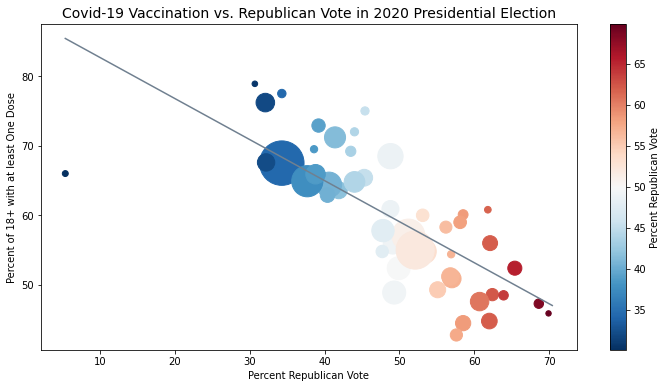

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
votevax.plot.scatter(x="Percent Republican Vote", y="Percent of 18+ with at least One Dose",
                    c="Percent Republican Vote", cmap="RdBu_r", vmin=color_min,
                    s=votevax["Population"]/20000, ax=ax)

x = np.arange(votevax["Percent Republican Vote"].min(), votevax["Percent Republican Vote"].max() + 1)
ax.plot(x, x * model.coef_[0] + model.intercept_, color="SlateGray")
ax.set_title("Covid-19 Vaccination vs. Republican Vote in 2020 Presidential Election", fontsize=14)
plt.show()

Incidentally, the dark blue outlier is the District of Columbia, which only voted 5.4% for Trump in 2020.

In [11]:
print(f"Washington D.C. ought to be {model.predict([[5.4]])[0]:0.0f}% vaccinated if this regression were accurate!")

Washington D.C. ought to be 85% vaccinated if this regression were accurate!


Clearly the correlation is not perfect, but it certainly is suggestive.

Alissa McFarlin 5/20/2021